In [2]:
import os
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../paper.mcstyle')

import seaborn as sns
import pandas as pd

import numpy as np
from scipy.stats import norm

import torch
import sbibm
import yaml
from tqdm import tqdm

In [3]:
cfgdir = './configs'
wdir = './slcp'

## Generate configurations

In [4]:
# create record csv

model_names = ['npe', 'nle', 'nre']#, 'SNPE', 'SNLE', 'SNRE']
Ns = [1_000, 10_000, 100_000]
seqNs = [n//10 for n in Ns]
obs = range(1,11)

rec = []
for i in obs:
    for m in model_names:
        if m[0] == 'S':
            for n in seqNs:
                rec.append([
                    m, n, i, 1,
                    f'./slcp/res/{m}_obs{i}_N{n}'
                ])
        else:
            for n in Ns:
                rec.append([
                    m, n, i, 0,
                    f'./slcp/res/{m}_obs{i}_N{n}'
                ])
print(len(rec))


# Save as csv
df = pd.DataFrame(rec, columns=['model', 'N', 'obs', 'seq', 'dir'])

# filename = join(cfgdir, 'record.csv')
# df.to_csv(filename, index=False)

# filename = join(cfgdir, 'batch.csv')
# df[['obs', 'N', 'seq', 'model']].to_csv(filename, index=False, header=False)

df

90


,model,N,obs,seq,dir
0,npe,1000,1,0,./slcp/res/npe_obs1_N1000
1,npe,10000,1,0,./slcp/res/npe_obs1_N10000
2,npe,100000,1,0,./slcp/res/npe_obs1_N100000
3,nle,1000,1,0,./slcp/res/nle_obs1_N1000
4,nle,10000,1,0,./slcp/res/nle_obs1_N10000
...,...,...,...,...,...
85,nle,10000,10,0,./slcp/res/nle_obs10_N10000
86,nle,100000,10,0,./slcp/res/nle_obs10_N100000
87,nre,1000,10,0,./slcp/res/nre_obs10_N1000
88,nre,10000,10,0,./slcp/res/nre_obs10_N10000


## Measure which have run

In [5]:
filename = join(cfgdir, 'record.csv')
record = pd.read_csv(filename)
record['done'] = False

for i, row in record.iterrows():
    record.loc[i, 'done'] = os.path.exists(join(row['dir'], 'single_samples.npy'))

In [6]:
print('len(record):', len(record))
record.groupby(['model','N'])['done'].sum()

len(record): 90


model  N     
nle    1000      5
       10000     5
       100000    5
npe    1000      5
       10000     5
       100000    4
nre    1000      5
       10000     5
       100000    5
Name: done, dtype: int64

In [7]:
ref = np.load(join(wdir, 'ref.npy'))

x_ = np.load(join(record.loc[0, 'dir'], 'single_samples.npy'))
x_.shape, ref.shape, record.loc[0, 'dir']

((10000, 5), (10, 10000, 5), './slcp/res/npe_obs1_N1000')

In [8]:
from sbibm.metrics.c2st import c2st
from sbibm.metrics.mmd import mmd

x_ = torch.Tensor(x_)
ref = torch.Tensor(ref)
# c2st(x_, ref[0])
mmd(ref[0], x_).item(), mmd(x_, ref[0]).item()

(0.12859582901000977, 0.12880825996398926)

In [15]:
for i in tqdm(range(len(record))):
    row = record.loc[i]
    if row['done']:
        metrics = np.load(join(row['dir'], 'metrics.npy'), allow_pickle=True).item()
        record.loc[i, 'mmd'] = metrics['mmd']
        record.loc[i, 'c2st'] = metrics['c2st']

100%|██████████| 90/90 [00:00<00:00, 2825.08it/s]


In [22]:
rec = record.dropna(axis=0)
percs = rec.groupby(['model','N'])['c2st'].apply(np.percentile, [5,50,95])
percs

model  N     
nle    1000      [0.9627200126647949, 0.9853500127792358, 0.989...
       10000     [0.8271199941635132, 0.878000020980835, 0.9175...
       100000    [0.615779983997345, 0.6262999773025513, 0.7100...
npe    1000      [0.9478500127792359, 0.9681000113487244, 0.989...
       10000     [0.8451299786567688, 0.9042500257492065, 0.940...
       100000    [0.6863974839448929, 0.8469499945640564, 0.884...
nre    1000      [0.9713399887084961, 0.984749972820282, 0.9895...
       10000     [0.9357100248336792, 0.9652500152587891, 0.983...
       100000    [0.8563000202178955, 0.9207500219345093, 0.958...
Name: c2st, dtype: object

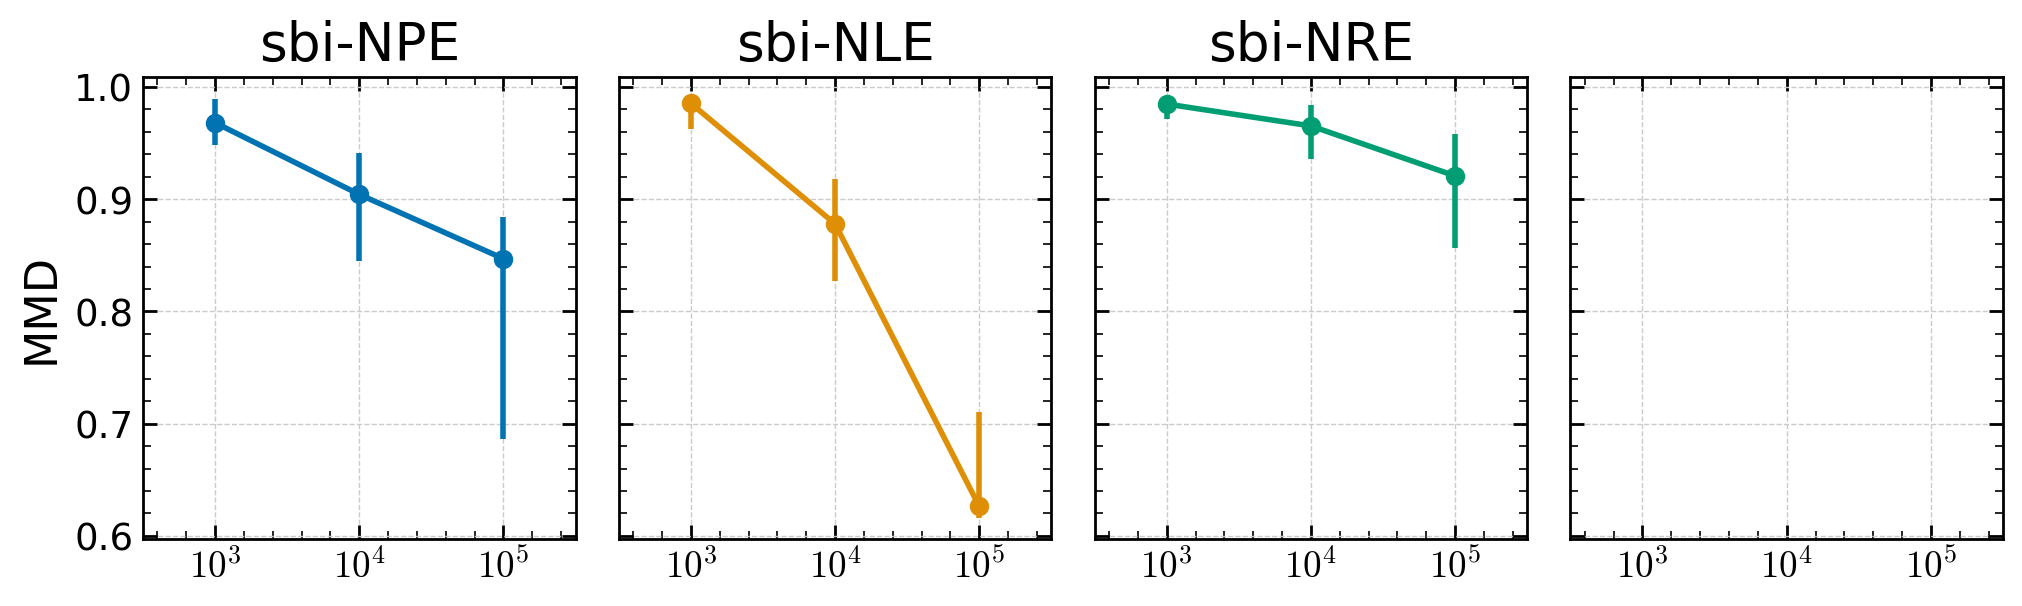

In [23]:
from math import ceil

keys = ['npe', 'nle', 'nre']
names = ['sbi-NPE', 'sbi-NLE', 'sbi-NRE']
cs = sns.color_palette('colorblind', n_colors=len(keys))

N = len(keys)
Ncol = 4
Nrow = ceil(N/Ncol)
f, axs = plt.subplots(Nrow, Ncol, figsize=(Ncol*3, Nrow*3),
                      sharex=True, sharey=True, gridspec_kw={'hspace':0.1, 'wspace':0.1})
axs = axs.flatten()

for i, m in enumerate(keys):
    ax = axs[i]
    p = np.stack(percs.loc[m].values)
    ax.errorbar(
        x=range(len(p)),
        y=p[:,1],
        yerr=[p[:,1]-p[:,0], p[:,2]-p[:,1]],
        fmt='o-',
        color=cs[i],
    )
    ax.set_title(names[i])
    ax.set_xlim(-0.5, 2.5)
    ax.set_xticks(range(3), [f"$10^{i}$" for i in range(3,6)])
    
    if i%Ncol == 0:
        ax.set_ylabel('MMD')

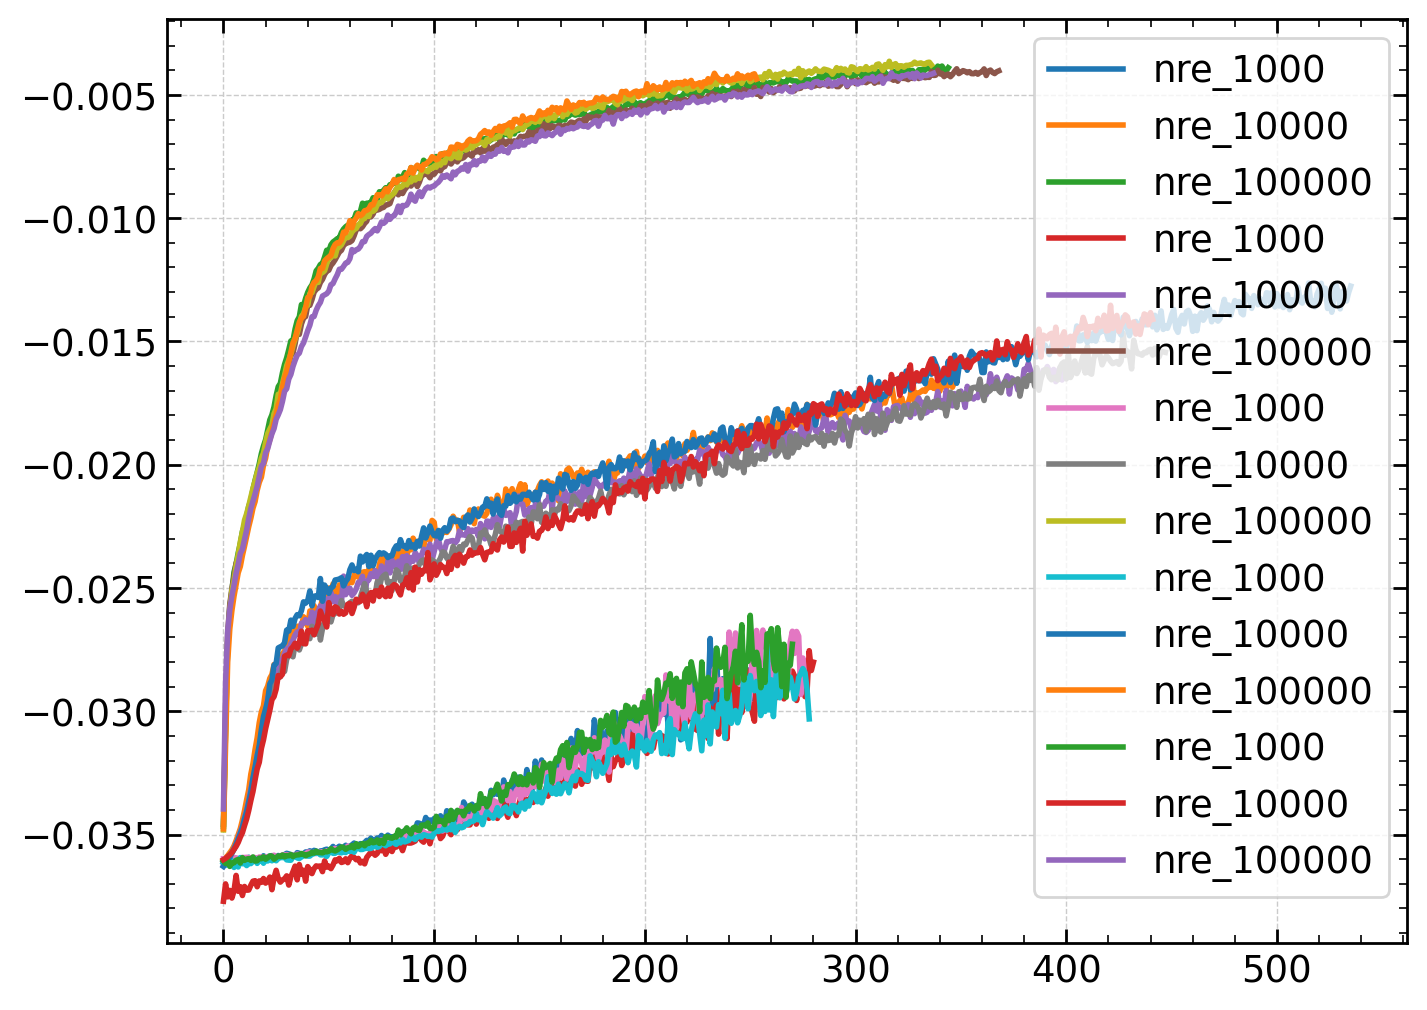

In [14]:
import json 

model = 'nre'
for i, row in record.iterrows():
    if not row['done']:
        continue
    if row['model'] != model:
        continue
    summ =  json.load(open(join(row['dir'], 'summary.json')))[0]
    val_loss = summ['validation_log_probs']

    plt.plot(val_loss, label=f"{row['model']}_{row['N']}")
plt.legend()

# Scratch

In [9]:
task = sbibm.get_task("slcp")
prior = task.get_prior()
simulator = task.get_simulator()
observation = task.get_observation(num_observation=5)

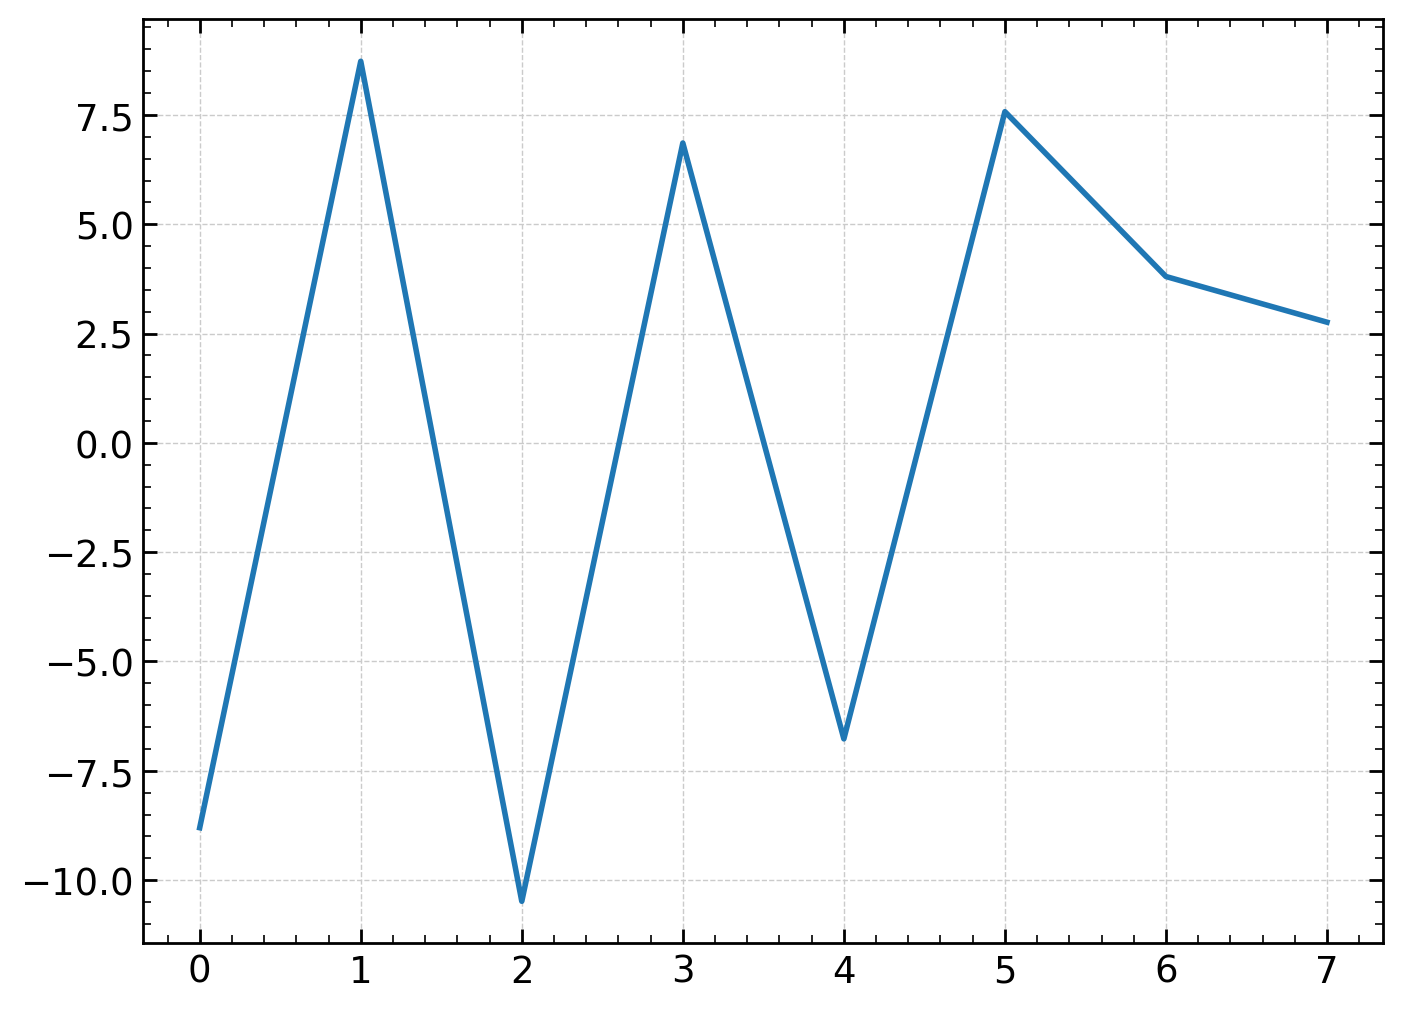

In [10]:
plt.plot(observation[0])

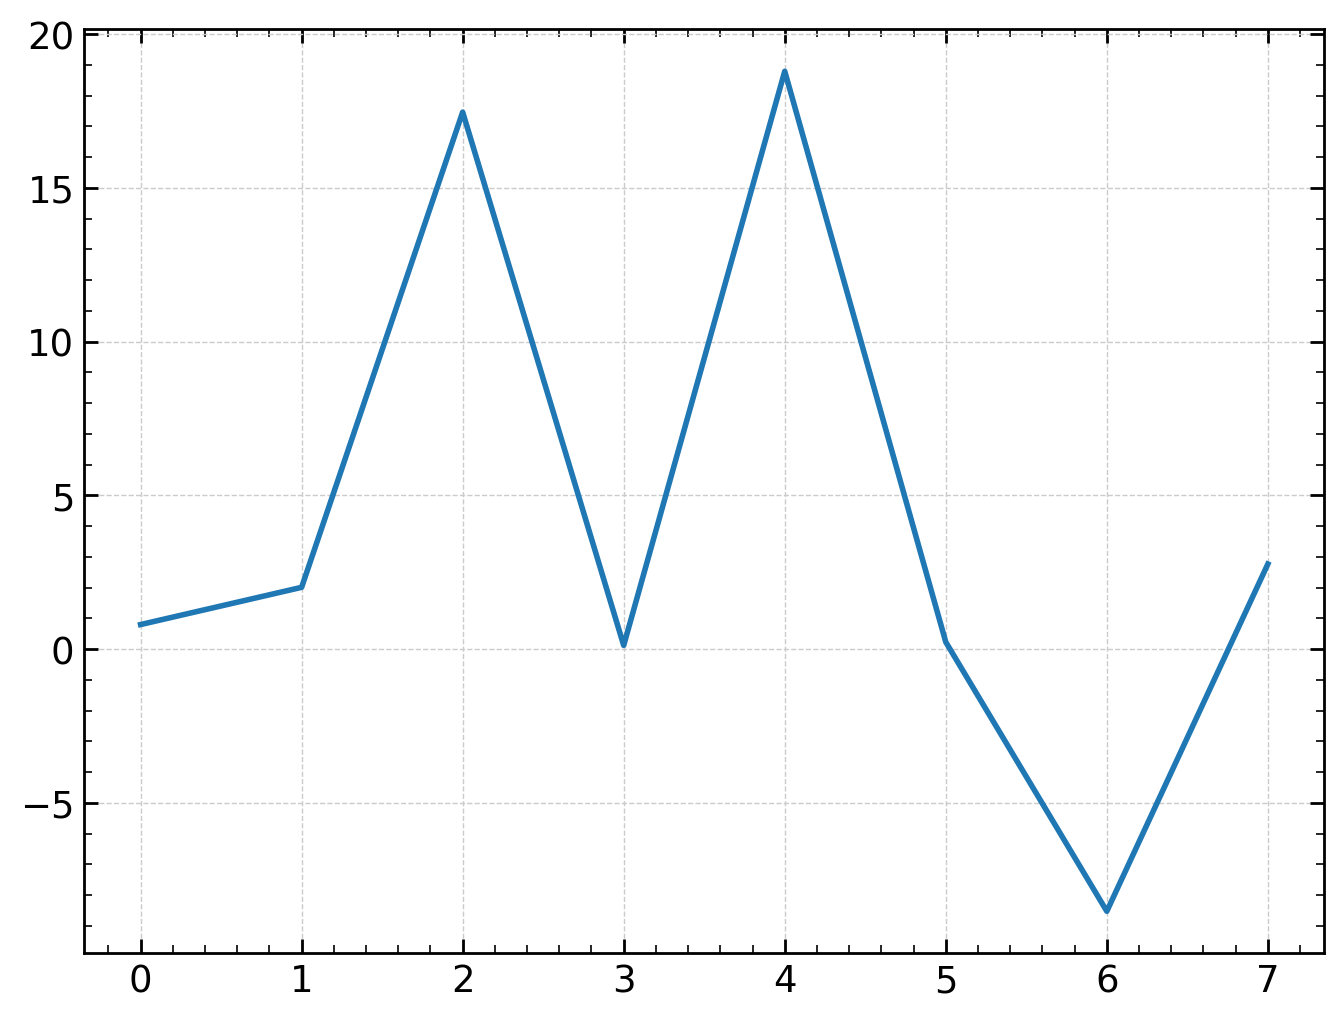

In [18]:
x0 = simulator(torch.tensor([1,2,3,-1,-2]))
plt.plot(x0[0])